Hi all, for the given task I will be designing my notebook into following sections:



1.   [Introduction](#Introduction)
  1.   Task
  2.   Dataset

2.   [Load packages, data and conduct initial EDA](#Load-packages,-data-and-conduct-initial-EDA)


3. [Try Building and Fine Tuning own BERT model using Transformers](#Try-Building-and-Fine-Tuning-own-BERT-model-using-Transformers)

  1.   Prepare the sentences and labels for fine tuning
  2.   FIT BERT for Name Entity Recognition
  3. Visualise the training loss
  4. Apply the model on new sentence
  5. Testing on test data
  6. Evaluation


4. [Achieve same using Simple Transformer package](#Achieve-same-using-Simple-Transformer-package)

    1. Configure model
    2. Training our model
    3. Predict Results on Test data
    4. Evaluation

5. [Lessons Learnt and Potential Improvements](#Lessons-Learnt-and-Potential-Improvements)

6. [Learning Resources](#Learning-Resources)



# Introduction

**Task:** 

The key achievement of this task is to create an algorithm which will detect name entities.

Name Entity Extraction (NER) consist of designing an algorithm to extract only key pieces of information or entities and categorize them into relevant type such as Person, Location, Date, Currency or could be any TAGS as per requirement.  


**Dataset:**

So I need to use the MIT Movie Corpus which is a semantically tagged training and test corpus in BIO format. The eng corpus are simple queries, and the trivia10k13 corpus are more complex queries. They can be found here:

https://groups.csail.mit.edu/sls/downloads/movie/

So I will use the trivia10k13 corpus to create an algorithm to detect Entities.


# Load packages, data and conduct initial EDA

In [1]:
# Please install below packages before running the notebook

#!pip install transformers
#!pip install seqeval
#!pip install simpletransformers



In [2]:
import os
import pandas as pd
import numpy as np
import itertools
from tqdm import tqdm, trange
import transformers
from transformers import BertForTokenClassification, AdamW
print(transformers.__version__)
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig
from transformers import get_linear_schedule_with_warmup
from seqeval.metrics import f1_score, accuracy_score, classification_report

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

print(torch.__version__)
import logging
from simpletransformers.ner import NERModel, NERArgs
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

4.10.2
1.9.0+cu102


As we know that the dataset is in CONLL data format, I will be writing a function to combine data with entities and finally take them in pandas dataframe for further analysis.

In [3]:
def load_sentences(filepath):
    # Simple data pre-processing function for taking file as input
    # and then converting it to list of tupple which consist 
    # [(unqiue_sentence_id, word, tag)]
    sentences = []
    with open(filepath, 'r') as f:
        i=0
        for line in f.readlines():
          if (line == '\n'):
            i+=1
          else:
              l = line.split('\t')
              sentences.append((i,l[0], l[1].strip('\n')))          
              
    return sentences

In [4]:
# Pre-processing the training and testing data
train_list_tupple = load_sentences('trivia10k13train.bio')
test_list_tupple = load_sentences('trivia10k13test.bio')

# Using the output list of tupples to generate dataframes
train_data = pd.DataFrame(train_list_tupple, columns=['sentence_id', 'Tag', 'Word'])
print(train_data.shape)
test_data = pd.DataFrame(test_list_tupple, columns=['sentence_id', 'Tag', 'Word'])
print(test_data.shape)

(158823, 3)
(39035, 3)


In [5]:
train_data.head()

,sentence_id,Tag,Word
0,0,B-Actor,steve
1,0,I-Actor,mcqueen
2,0,O,provided
3,0,O,a
4,0,B-Plot,thrilling


In [6]:
test_data.tail()

,sentence_id,Tag,Word
39030,1952,I-Origin,the
39031,1952,I-Origin,novel
39032,1952,I-Origin,by
39033,1952,I-Origin,ben
39034,1952,I-Origin,sherwood


**Conduct Initial Exploratory data analysis**

In [7]:
# What will be the unique Name Entities which our data contains
labels = train_data["Tag"].unique().tolist()
labels

['B-Actor',
 'I-Actor',
 'O',
 'B-Plot',
 'I-Plot',
 'B-Opinion',
 'I-Opinion',
 'B-Award',
 'I-Award',
 'B-Year',
 'B-Genre',
 'B-Origin',
 'I-Origin',
 'B-Director',
 'I-Director',
 'I-Genre',
 'I-Year',
 'B-Soundtrack',
 'I-Soundtrack',
 'B-Relationship',
 'I-Relationship',
 'B-Character_Name',
 'I-Character_Name',
 'B-Quote',
 'I-Quote']

In [8]:
# Let us do a value count to see if we have sufficient balanced data per Tag
train_data["Tag"].value_counts()

I-Plot              62107
O                   55895
B-Plot               6468
I-Actor              6121
B-Actor              5010
B-Genre              3384
I-Origin             3340
B-Year               2702
I-Genre              2283
B-Director           1787
I-Director           1653
I-Relationship       1206
B-Character_Name     1025
I-Quote               817
B-Opinion             810
B-Origin              779
I-Character_Name      760
I-Award               719
B-Relationship        580
I-Opinion             539
B-Award               309
I-Year                195
I-Soundtrack          158
B-Quote               126
B-Soundtrack           50
Name: Tag, dtype: int64

In [9]:
# See total number of sentences in training data
train_data['sentence_id'].max()

7815

# Try Building and Fine Tuning own BERT model using Transformers

There are already pre existing sequence labelling techniques in NER detection like Conditional Random Field (CRF),   Markov models or LSTM.

However, with the invention of **Bidirectional Encoder Representations from Transformers (BERT)** which is an extremely powerful general-purpose model that can be leveraged for nearly every text-based machine learning task. Rather than training models from scratch, the new paradigm in natural language processing (NLP) is to select an off-the-shelf model that has been trained on the task of “language modeling” (predicting which words belong in a sentence), then “fine-tuning” the model with data from your specific task. The performance boost gained by combining BERT’s flexible Transformer architecture with pre-training on the novel Masked Language Modeling task has swiftly made BERT the dominant model for transfer learning in the NLP space.

***So I have decided to Fine tune BERT for our task, which I will be doing using 2 ways.***

1. Try Fine Tunning BERT using pytorch and transformers library

2. Use easy transformer package which makes our life much easy

**Prepare the sentences and labels**

Before we can start fine-tuning the model, we have to prepare the data set for the use with pytorch and BERT.

In [10]:
# Let us prepare our dataset for training, I will start with train_data first

class SentenceGetter(object):
    # creating tokens by grouping on individual sentence_id and creating list
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w,  t) for w, t in zip(s["Word"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("sentence_id").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [11]:
getter = SentenceGetter(train_data)
print(train_data.shape)
#This is how the sentences in the dataset look like.
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
print('word tokens in sentence')
print(sentences[0])
print('Total sentences: '+str(len(sentences)))
#The sentences are annotated with the BIO-schema and the labels look like this.
labels = [[s[1] for s in sentence] for sentence in getter.sentences]
print('Label Tags per Word of sentence')
print(labels[0])

(158823, 3)
word tokens in sentence
['steve', 'mcqueen', 'provided', 'a', 'thrilling', 'motorcycle', 'chase', 'in', 'this', 'greatest', 'of', 'all', 'ww', '2', 'prison', 'escape', 'movies']
Total sentences: 7816
Label Tags per Word of sentence
['B-Actor', 'I-Actor', 'O', 'O', 'B-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'B-Opinion', 'I-Opinion', 'I-Opinion', 'B-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot']


In [12]:
# Creating unique list of TAG values which we need to predict
tag_values = list(set(train_data["Tag"].values))

# I will add a PAD token to that, which we need later part of processing,
# The PAD token will be used to ensure all sentences are of same length 
# and sentence of small length will have extra pad token which adds no value
tag_values.append("PAD")
print(tag_values)

# Encoding the tags for later processing
tag2idx = {t: i for i, t in enumerate(tag_values)}
print(tag2idx)

['B-Relationship', 'I-Relationship', 'I-Quote', 'O', 'B-Year', 'B-Genre', 'B-Character_Name', 'I-Actor', 'I-Plot', 'I-Soundtrack', 'B-Plot', 'I-Award', 'I-Character_Name', 'B-Soundtrack', 'I-Origin', 'B-Award', 'B-Quote', 'I-Opinion', 'I-Director', 'B-Actor', 'I-Year', 'I-Genre', 'B-Opinion', 'B-Origin', 'B-Director', 'PAD']
{'B-Relationship': 0, 'I-Relationship': 1, 'I-Quote': 2, 'O': 3, 'B-Year': 4, 'B-Genre': 5, 'B-Character_Name': 6, 'I-Actor': 7, 'I-Plot': 8, 'I-Soundtrack': 9, 'B-Plot': 10, 'I-Award': 11, 'I-Character_Name': 12, 'B-Soundtrack': 13, 'I-Origin': 14, 'B-Award': 15, 'B-Quote': 16, 'I-Opinion': 17, 'I-Director': 18, 'B-Actor': 19, 'I-Year': 20, 'I-Genre': 21, 'B-Opinion': 22, 'B-Origin': 23, 'B-Director': 24, 'PAD': 25}


The Bert implementation comes with a pretrained tokenizer and a definied vocabulary. We load the one related to the smallest pre-trained model bert-base-cased. We use the cased variate since it is well suited for NER.

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)


INFO:filelock:Lock 140612965060048 acquired on /root/.cache/huggingface/transformers/6508e60ab3c1200bffa26c95f4b58ac6b6d95fba4db1f195f632fa3cd7bc64cc.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791.lock


Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

INFO:filelock:Lock 140612965060048 released on /root/.cache/huggingface/transformers/6508e60ab3c1200bffa26c95f4b58ac6b6d95fba4db1f195f632fa3cd7bc64cc.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791.lock
INFO:filelock:Lock 140612964360016 acquired on /root/.cache/huggingface/transformers/ec84e86ee39bfe112543192cf981deebf7e6cbe8c91b8f7f8f63c9be44366158.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f.lock


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

INFO:filelock:Lock 140612964360016 released on /root/.cache/huggingface/transformers/ec84e86ee39bfe112543192cf981deebf7e6cbe8c91b8f7f8f63c9be44366158.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f.lock
INFO:filelock:Lock 140612947227344 acquired on /root/.cache/huggingface/transformers/226a307193a9f4344264cdc76a12988448a25345ba172f2c7421f3b6810fddad.3dab63143af66769bbb35e3811f75f7e16b2320e12b7935e216bd6159ce6d9a6.lock


Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

INFO:filelock:Lock 140612947227344 released on /root/.cache/huggingface/transformers/226a307193a9f4344264cdc76a12988448a25345ba172f2c7421f3b6810fddad.3dab63143af66769bbb35e3811f75f7e16b2320e12b7935e216bd6159ce6d9a6.lock
INFO:filelock:Lock 140612947241872 acquired on /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307.lock


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

INFO:filelock:Lock 140612947241872 released on /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307.lock


Now we tokenize all sentences. Since the BERT tokenizer is based a Wordpiece tokenizer it will split tokens in subword tokens. For example ‘gunships’ will be split in the two tokens ‘guns’ and ‘##hips’. We have to deal with the issue of splitting our token-level labels to related subtokens. In practice you would solve this by a specialized data structure based on label spans, but for simplicity I do it explicitly here.

In [14]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [15]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
print(tokenized_texts[0])
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]
print(labels[0])

['s', '##te', '##ve', 'm', '##c', '##que', '##en', 'provided', 'a', 'thrill', '##ing', 'motorcycle', 'chase', 'in', 'this', 'greatest', 'of', 'all', 'w', '##w', '2', 'prison', 'escape', 'movies']
['B-Actor', 'B-Actor', 'B-Actor', 'I-Actor', 'I-Actor', 'I-Actor', 'I-Actor', 'O', 'O', 'B-Plot', 'B-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'B-Opinion', 'I-Opinion', 'I-Opinion', 'B-Plot', 'B-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot']


In [16]:
print(len(tokenized_texts[0]))
print(len(labels[0]))

24
24


Here I fix some configurations. Limiting our sequence length to 75 tokens and we will use a batch size of 32 as suggested by the Bert paper. Note, that Bert supports sequences of up to 512 tokens.

In [17]:
MAX_LEN = 75
bs = 32

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print(torch.cuda.get_device_name(0))


Tesla K80


Next, we cut and pad the token and label sequences to our desired length.

In [19]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")
print('Let us see how encoded and padded input data looks for 1st sentence')
print('Input padded sentence length ===>'+str(len(input_ids[0])))
print(input_ids[0])

Let us see how encoded and padded input data looks for 1st sentence
Input padded sentence length ===>75
[  188  1566  2707   182  1665  3530  1424  2136   170 21401  1158  9580
  9839  1107  1142  4459  1104  1155   192  2246   123  3315  3359  5558
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]


In [20]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")
print('Similarly we see label encoded')
print('Input padded label length ===>'+str(len(tags[0])))
print(tags[0])

Similarly we see label encoded
Input padded label length ===>75
[19 19 19  7  7  7  7  3  3 10 10  8  8  8  8 22 17 17 10 10  8  8  8  8
 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25
 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25
 25 25 25]


The Bert model supports something called attention_mask, which is similar to the masking in keras. So here we create the mask to ignore the padded elements in the sequences.

In [21]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]
print('Now see how we smartly create attention mask from input tokens to ignore padding bits')
print('Mask padded label length ===>'+str(len(attention_masks[0])))
print(attention_masks[0])

Now see how we smartly create attention mask from input tokens to ignore padding bits
Mask padded label length ===>75
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Now we split the dataset to use 20% to validate the model.

In [22]:
#tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,random_state=1416, test_size=0.2)
#tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,random_state=1416, test_size=0.2)

In [23]:
print('Number of training data input sentences: '+str(len(input_ids)))


Number of training data input sentences: 7816


In [24]:
tr_inputs = input_ids[:6253]
val_inputs = input_ids[6253:]
tr_tags = tags[:6253]
val_tags = tags[6253:]
tr_masks = attention_masks[:6253]
val_masks = attention_masks[6253:]
print(len(tr_inputs))
print(len(val_inputs))


6253
1563


Since we’re operating in pytorch, we have to convert the dataset to torch tensors.

In [25]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

The last step is to define the dataloaders.
We shuffle the data at training time with the RandomSampler and at test time we just pass them sequentially with the SequentialSampler.


However, I tried that method and found my model to perform very poorly, given its sequence detection task, BERT would not train properly.

So I will be using Sequential sampler for both training and validation data. 

In [26]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
#train_sampler = RandomSampler(train_data)
train_sampler = SequentialSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

The transformer package provides a BertForTokenClassification class for token-level predictions. BertForTokenClassification is a fine-tuning model that wraps BertModel and adds token-level classifier on top of the BertModel. The token-level classifier is a linear layer that takes as input the last hidden state of the sequence. We load the pre-trained bert-base-cased model and provide the number of possible labels.

In [27]:
#from transformers import BertForTokenClassification, AdamW
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

INFO:filelock:Lock 140612873195088 acquired on /root/.cache/huggingface/transformers/092cc582560fc3833e556b3f833695c26343cb54b7e88cd02d40821462a74999.1f48cab6c959fc6c360d22bea39d06959e90f5b002e77e836d2da45464875cda.lock


Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

INFO:filelock:Lock 140612873195088 released on /root/.cache/huggingface/transformers/092cc582560fc3833e556b3f833695c26343cb54b7e88cd02d40821462a74999.1f48cab6c959fc6c360d22bea39d06959e90f5b002e77e836d2da45464875cda.lock
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be e

Now we have to pass the model parameters to the GPU.

In [28]:
model.cuda()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

Before we can start the fine-tuning process, we have to setup the optimizer and add the parameters it should update. A common choice is the AdamW optimizer. We also add some weight_decay as regularization to the main weight matrices. If you have limited resources, you can also try to just train the linear classifier on top of BERT and keep all other weights fixed. This will still give you a good performance.

In [29]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    #lr=3e-5,
    lr=1e-4,
    eps=1e-8
)

We also add a scheduler to linearly reduce the learning rate throughout the epochs.

In [30]:
#from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

**Fit BERT for named entity recognition**


First we define some metrics, we want to track while training. We use the f1_score from the seqeval package. You ca find more details here. And we use simple accuracy on a token level comparable to the accuracy in keras.


Finally, we can finetune the model. A few epochs should be enougth. The paper suggest 3-4 epochs.

In [31]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    #print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Average train loss: 0.6520022325673882


Epoch:  33%|███▎      | 1/3 [02:46<05:33, 166.90s/it]

Validation loss: 0.37919747129994996
Validation Accuracy: 0.8817141847016339

Average train loss: 0.332513620278665


Epoch:  67%|██████▋   | 2/3 [05:33<02:46, 166.92s/it]

Validation loss: 0.38103887195489844
Validation Accuracy: 0.8840627288567893

Average train loss: 0.22560103484714517


Epoch: 100%|██████████| 3/3 [08:20<00:00, 166.90s/it]

Validation loss: 0.3501680984484906
Validation Accuracy: 0.8959317154473598



**Visualize the training loss**

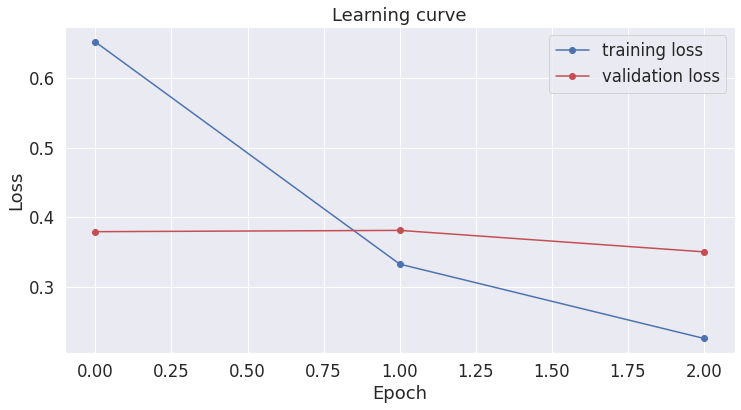

In [32]:
#import matplotlib.pyplot as plt
#%matplotlib inline
#import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

**Apply the model to a new sentence**


Before I go with test data and accuracy metrics I want to test the model to identify named entities in new text. I just made up my own sentences which have some movie plot and tried to see is it good enough.

In [33]:
test_sentence_1 = """
In the movie the script actor Piyush Rumao played an excellent part of the Hulk, beating the villans and saving the earth from Nuclear war.
"""

test_sentence_2 = "Anisa Tuscano directed a movie called Aliens attacking the earth"

In [34]:
tokenized_sentence_3 = tokenizer.encode(test_sentence_1,test_sentence_2)

input_ids = torch.tensor([tokenized_sentence_3]).cuda()
print(input_ids)

#Now we can run the sentence through the model.
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

print(label_indices)
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))


tensor([[  101,  1130,  1103,  2523,  1103,  5444,  2811, 21902,  9379,  2737,
           155, 10161,  1186,  1307,  1126,  6548,  1226,  1104,  1103, 19408,
           117,  5405,  1103, 15282,  2316,  1105,  7740,  1103,  4033,  1121,
         11560,  1594,   119,   102,  1760, 15630, 17037, 26996,  2728,  2002,
           170,  2523,  1270, 19637,  1116,  7492,  1103,  4033,   102]],
       device='cuda:0')
[[ 3  3  3  3  3  3  3 19 19 19  7  7  7  3  3  3  3  3  3  8  3  8  8  8
   8  8  8  8  8  8  8  8  3  3 24 24 18 18 18  3  3  3  3 10 10  8  8  8
   3]]
O	[CLS]
O	In
O	the
O	movie
O	the
O	script
O	actor
B-Actor	Piyush
I-Actor	Rumao
O	played
O	an
O	excellent
O	part
O	of
O	the
I-Plot	Hulk
O	,
I-Plot	beating
I-Plot	the
I-Plot	villans
I-Plot	and
I-Plot	saving
I-Plot	the
I-Plot	earth
I-Plot	from
I-Plot	Nuclear
I-Plot	war
O	.
O	[SEP]
B-Director	Anisa
I-Director	Tuscano
O	directed
O	a
O	movie
O	called
B-Plot	Aliens
I-Plot	attacking
I-Plot	the
I-Plot	earth
O	[SEP]


**Testing on Test data**

In [35]:
print(test_data.shape)
test_data.head()

(39035, 3)


,sentence_id,Tag,Word
0,0,O,i
1,0,O,need
2,0,O,that
3,0,O,movie
4,0,O,which


In [36]:
# Aggregating at sentence level
test_data_1 = test_data.groupby('sentence_id', as_index = False).agg({'Word': ' '.join})
print(test_data_1.shape)
test_data_1.head()

(1953, 2)


,sentence_id,Word
0,0,i need that movie which involves aliens invadi...
1,1,what soviet science fiction classic about a my...
2,2,this american classic based on margaret mitche...
3,3,what is the movie starring jessica biel from 2...
4,4,in this movie ryan reynolds plays a superhero ...


In [37]:
# Extracting text column as list
test_list = test_data_1["Word"].to_list()
print('Total number of test samples: '+str(len(test_list)))
test_list[:2]

Total number of test samples: 1953


['i need that movie which involves aliens invading earth in a particular united states place in california',
 'what soviet science fiction classic about a mysterious planet was later remade by steven soderbergh and george clooney']

In [ ]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")
print('Similarly we see label encoded')
print('Input padded label length ===>'+str(len(tags[0])))
print(tags[0])

In [38]:
tokenized_sentence_test_df = tokenizer(test_list, truncation= True, padding= True, return_tensors="pt")
#tokenized_sentence_test_df = tokenizer.batch_encode_plus(test_list)
print(tokenized_sentence_test_df)
print(tokenized_sentence_test_df['input_ids'])
print(len(tokenized_sentence_test_df['input_ids']))
input_ids = torch.tensor(tokenized_sentence_test_df['input_ids']).cuda()
print(input_ids)

# Run model prediction on input tokenized tensors
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)
print(label_indices)



{'input_ids': tensor([[ 101,  178, 1444,  ...,    0,    0,    0],
        [ 101, 1184, 1177,  ...,    0,    0,    0],
        [ 101, 1142, 1821,  ...,    0,    0,    0],
        ...,
        [ 101, 1128, 1547,  ...,    0,    0,    0],
        [ 101, 1685,  191,  ...,    0,    0,    0],
        [ 101,  195, 7409,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}
tensor([[ 101,  178, 1444,  ...,    0,    0,    0],
        [ 101, 1184, 1177,  ...,    0,    0,    0],
        [ 101, 1142, 1821,  ...,    0,    0,    0],
        ...,
        [ 101, 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


[[ 3  3  3 ... 19 19 19]
 [ 3  3 24 ... 19 19 19]
 [ 3  3  5 ... 19 19 19]
 ...
 [ 3  3  3 ... 19 19 19]
 [ 3 10  6 ... 19 19 19]
 [ 3 19 19 ... 19 19 19]]


In [39]:
# join bpe split tokens

# this will be flat list containing all predicted tokens in sklearn format
predicted_labels = []

# this will be list of list with individual list containing per sentence tokens
predicted_labels_list = []

for i in range(len(label_indices)):
    tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[i])
    new_tokens, new_labels = [], []
    labels_wo_extra = []
    for token, label_idx in zip(tokens, label_indices[0]):
        if token.startswith("##"):
            new_tokens[-1] = new_tokens[-1] + token[2:]
        else:
            new_labels.append(tag_values[label_idx])
            new_tokens.append(token)
    for token, label in zip(new_tokens, new_labels):
      if token != '[PAD]' and token != '[CLS]' and token != '[SEP]':
        #print("{}\t{}".format(label, token))
        predicted_labels.append(label)
        labels_wo_extra.append(label)
    predicted_labels_list.append(labels_wo_extra)
    
print(len(predicted_labels))
print(len(predicted_labels_list))

39035
1953


In [40]:
# Let me add predicted tag as additional column to our test dataframe to see Actual vs Predicted predictions per word
test_data['Predicted_Tag'] = predicted_labels
print(test_data.shape)
test_data.head(30)

(39035, 4)


,sentence_id,Tag,Word,Predicted_Tag
0,0,O,i,O
1,0,O,need,O
2,0,O,that,O
3,0,O,movie,O
4,0,O,which,O
5,0,O,involves,O
6,0,B-Plot,aliens,B-Plot
7,0,I-Plot,invading,I-Plot
8,0,I-Plot,earth,I-Plot
9,0,I-Plot,in,I-Plot


In [41]:
# Getting true labels in sequel format for calculating accuracy
getter_test = SentenceGetter(test_data)

#The sentences are annotated with the BIO-schema and the labels look like this.
true_labels_test = [[s[1] for s in sentence] for sentence in getter_test.sentences]
print(true_labels_test[:2])
print(len(true_labels_test))
# Printing lenth of predicted labels 
print(len(predicted_labels_list))
print(predicted_labels_list[:2])

[['O', 'O', 'O', 'O', 'O', 'O', 'B-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot'], ['O', 'B-Genre', 'I-Genre', 'I-Genre', 'B-Opinion', 'O', 'B-Plot', 'I-Plot', 'I-Plot', 'O', 'O', 'B-Relationship', 'O', 'B-Director', 'I-Director', 'O', 'B-Actor', 'I-Actor']]
1953
1953
[['O', 'O', 'O', 'O', 'O', 'O', 'B-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot'], ['O', 'O', 'O', 'O', 'B-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'B-Actor', 'B-Actor', 'B-Actor']]


In [42]:
accuracy_score(true_labels_test, predicted_labels_list)	

0.43089535032662996

Let us see how well model performed on overall Tags, ie getting rid of B- or I- prefix and using just base tag

In [43]:
predicted_labels = [word.replace('B-','') for word in predicted_labels]
predicted_labels = [word.replace('I-','') for word in predicted_labels]
print(len(predicted_labels))
flat_list_true_labels = [item for sublist in true_labels_test for item in sublist]
print(len(flat_list_true_labels))
flat_list_true_labels = [word.replace('B-','') for word in flat_list_true_labels]
flat_list_true_labels = [word.replace('I-','') for word in flat_list_true_labels]
print(len(flat_list_true_labels))

labels = list(set(flat_list_true_labels))
print(labels)

39035
39035
39035
['Opinion', 'Genre', 'Origin', 'Soundtrack', 'Relationship', 'O', 'Character_Name', 'Plot', 'Award', 'Quote', 'Year', 'Director', 'Actor']


In [44]:
#import os

if not os.path.exists('output_matrix/'):
  os.mkdir('output_matrix/')

**** Classification Report ****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

       Opinion       0.06      0.15      0.09      2827
         Genre       0.00      0.00      0.00       213
        Origin       0.00      0.00      0.00       510
    Soundtrack       0.00      0.00      0.00       836
  Relationship       0.00      0.00      0.00      1333
             O       0.66      0.48      0.56     14143
Character_Name       0.00      0.00      0.00       338
          Plot       0.00      0.00      0.00       998
         Award       0.51      0.69      0.59     16238
         Quote       0.00      0.00      0.00       396
          Year       0.00      0.00      0.00       460
      Director       0.00      0.00      0.00        38
         Actor       0.00      0.00      0.00       705

      accuracy                           0.47     39035
     macro avg       0.09      0.10      0.09     39035
  weighted avg       0.46      0.47      0.45     39035



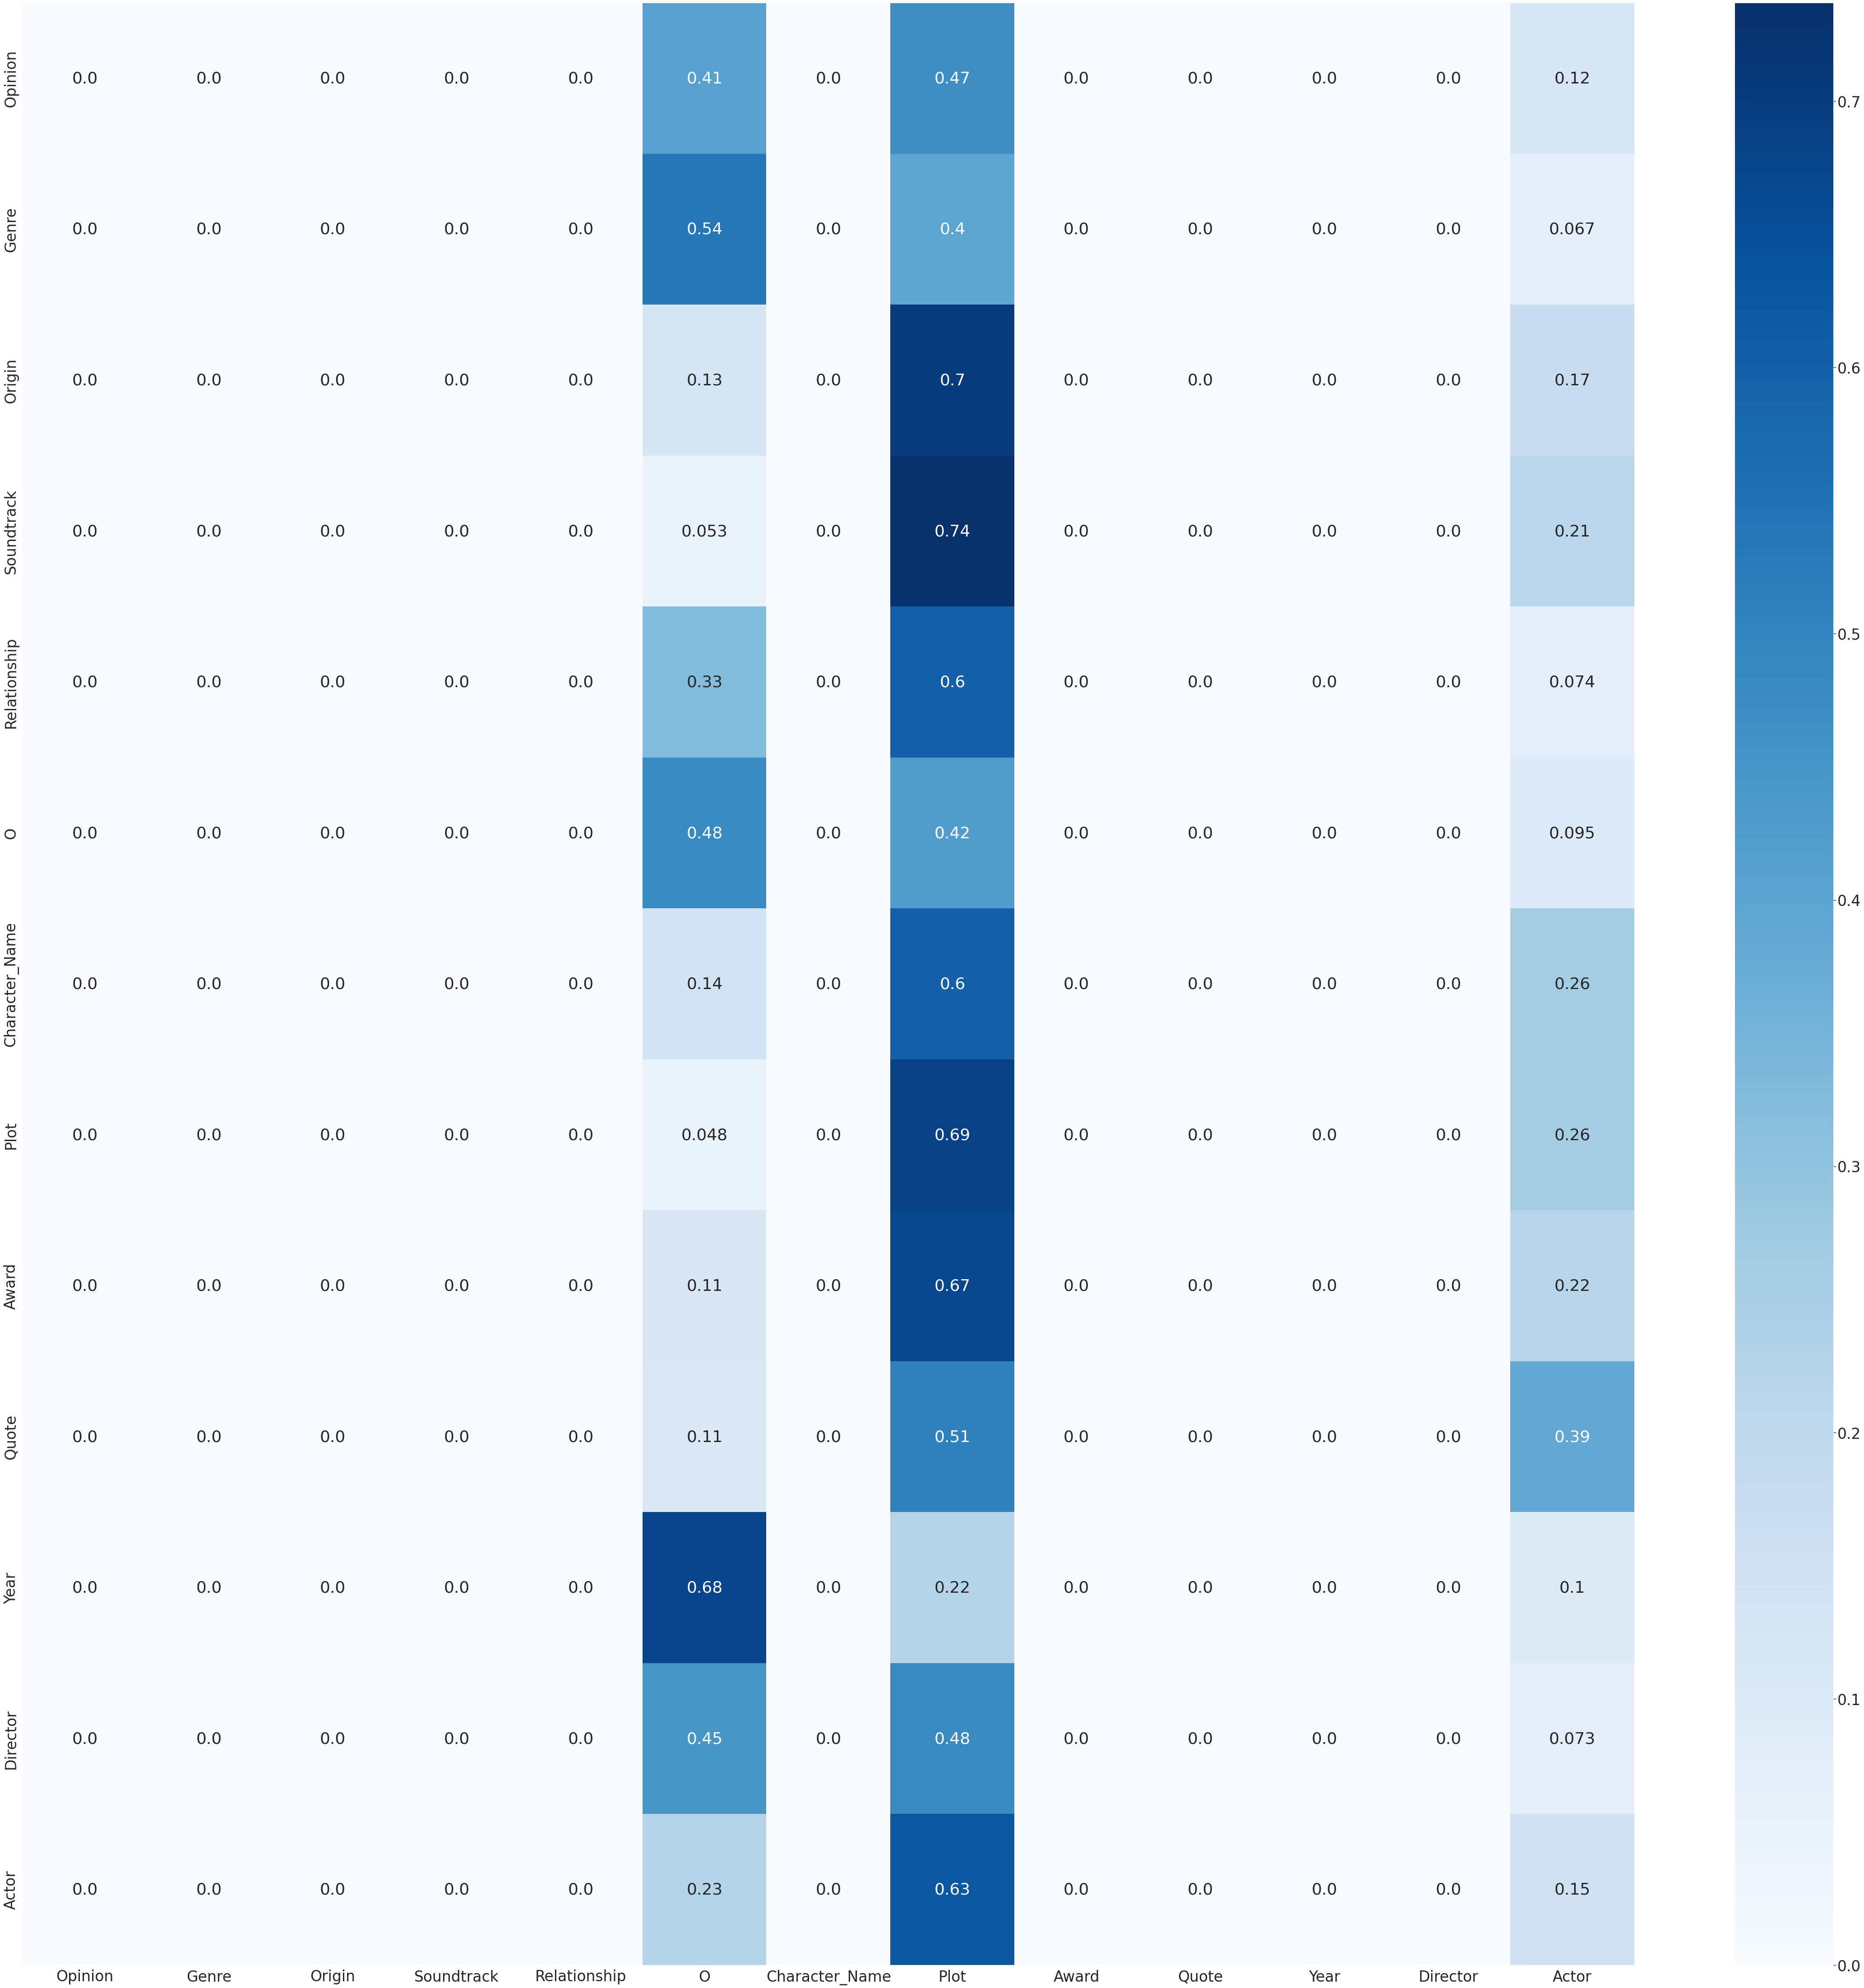

In [45]:
def plot_confusion_matrix(y_test,y_scores, classNames):
    #y_test=np.argmax(y_test, axis=1)
    #y_scores=np.argmax(y_scores, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores,labels=classNames)
    #print("**** Confusion Matrix ****")
    #print(cm)
    df_cm_ct = pd.DataFrame(cm).transpose()
    df_cm_ct.to_csv('output_matrix/custom_transformer_confusion_matrix.csv')
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    cr = classification_report(y_test, y_scores, target_names=classNames, output_dict=True)
    df_cr_ct = pd.DataFrame(cr).transpose()
    df_cr_ct.to_csv('output_matrix/custom_transformer_classification_report.csv')
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y]/np.sum(cm[x,:])

    plt.figure(figsize=(80,80))
    sns.set(font_scale=3.0) # for label size
    df = sns.heatmap(con, annot=True,fmt='.2', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    df.figure.savefig("output_matrix/custom_transformer_heat_map.png")


plot_confusion_matrix(flat_list_true_labels, predicted_labels, labels) 
#y_test is your ground truth
#y_scores is your predicted probabilities

# Achieve same using Simple Transformer package

Well the process that we followed above was fun and good learning resource but not feasible as it is prone to errors.

For making our fine tuning task easy there are multiple libraries which have created wrappers to fine tune BERT on top of hugging face transformers.

They are easy to use just like sklearn libraries and help fine tune in just 3 steps.

I would be showing the [simple transformer library](https://simpletransformers.ai/) which makes using transformer models even more simpler!

In [46]:
# we will be using the same training and testing dataframe created above

# Using the output list of tupples to generate dataframes
train_data = pd.DataFrame(train_list_tupple, columns=['sentence_id', 'labels', 'words'])
print(train_data.shape)
test_data = pd.DataFrame(test_list_tupple, columns=['sentence_id', 'labels', 'words'])
print(test_data.shape)

(158823, 3)
(39035, 3)


In [47]:
# Splitting training data in train and validation set
# I am not using the regular train-test split as I want to maintain the sequence

train_data_v1 = train_data[train_data['sentence_id'] < 6252]
print(train_data_v1.shape)
train_data_validation = train_data[train_data['sentence_id'] > 6252]
print(train_data_validation.shape)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


(127519, 3)
(31282, 3)


In [48]:
labels = train_data["labels"].unique().tolist()
print(labels)

['B-Actor', 'I-Actor', 'O', 'B-Plot', 'I-Plot', 'B-Opinion', 'I-Opinion', 'B-Award', 'I-Award', 'B-Year', 'B-Genre', 'B-Origin', 'I-Origin', 'B-Director', 'I-Director', 'I-Genre', 'I-Year', 'B-Soundtrack', 'I-Soundtrack', 'B-Relationship', 'I-Relationship', 'B-Character_Name', 'I-Character_Name', 'B-Quote', 'I-Quote']


**Configure our model**

In [49]:
#from simpletransformers.ner import NERModel, NERArgs

args = NERArgs()
args.num_train_epochs = 3
args.learning_rate = 1e-4
args.overwrite_output_dir =True
#args.wandb_project = "NER KPMG"
args.train_batch_size = 32
args.eval_batch_size = 32
args.classification_report = True

**Training our model**

Using training and validation data created above.
I am using ber-base-cased model, which we even used in our model above and passing model configuration



In [50]:
#model = NERModel('bert', 'bert-base-cased',labels=labels,args =args,use_cuda=False)
simple_transformer_model = NERModel('bert', 'bert-base-cased',labels=labels,args =args)

simple_transformer_model.train_model(train_data_v1,eval_data = train_data_validation,acc=accuracy_score)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/196 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/ner/ner_model.py:775: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  model.parameters(), args.max_grad_norm
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Running Epoch 1 of 3:   0%|          | 0/196 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/196 [00:00<?, ?it/s]

INFO:simpletransformers.ner.ner_model: Training of bert model complete. Saved to outputs/.


(588, 0.39198999878551277)

**Predict Results on Test data**

In [51]:
result, model_outputs, preds_list = simple_transformer_model.eval_model(test_data)


INFO:simpletransformers.ner.ner_model: Converting to features started.


  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/62 [00:00<?, ?it/s]

INFO:simpletransformers.ner.ner_model:{'eval_loss': 0.37423170418027907, 'precision': 0.6742969260954872, 'recall': 0.7252901864227929, 'f1_score': 0.6988645992204712}


In [52]:
print(result)

{'eval_loss': 0.37423170418027907, 'precision': 0.6742969260954872, 'recall': 0.7252901864227929, 'f1_score': 0.6988645992204712}


In [53]:
#import itertools

predicted_labels = list(itertools.chain(*preds_list))
print(len(predicted_labels))
actual_labels = test_data['labels']
print(len(actual_labels))

39035
39035


**** Classification Report ****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

         B-Actor       0.94      0.97      0.95      1274
         I-Actor       0.69      0.65      0.67        66
               O       0.69      0.70      0.70       283
          B-Plot       0.88      0.88      0.88       425
          I-Plot       0.82      0.86      0.84       789
       B-Opinion       0.46      0.47      0.47       195
       I-Opinion       0.52      0.51      0.51       190
         B-Award       0.59      0.54      0.56      1577
         I-Award       0.80      0.77      0.78        47
          B-Year       0.78      0.68      0.73       171
         B-Genre       0.00      0.00      0.00         8
        B-Origin       0.98      0.99      0.98       661
        I-Origin       0.96      0.96      0.96      1553
      B-Director       0.75      0.82      0.78       147
      I-Director       0.69      0.70      0.69       227
         I-Genre       0.94      0.91      0.92       411
          I-Y

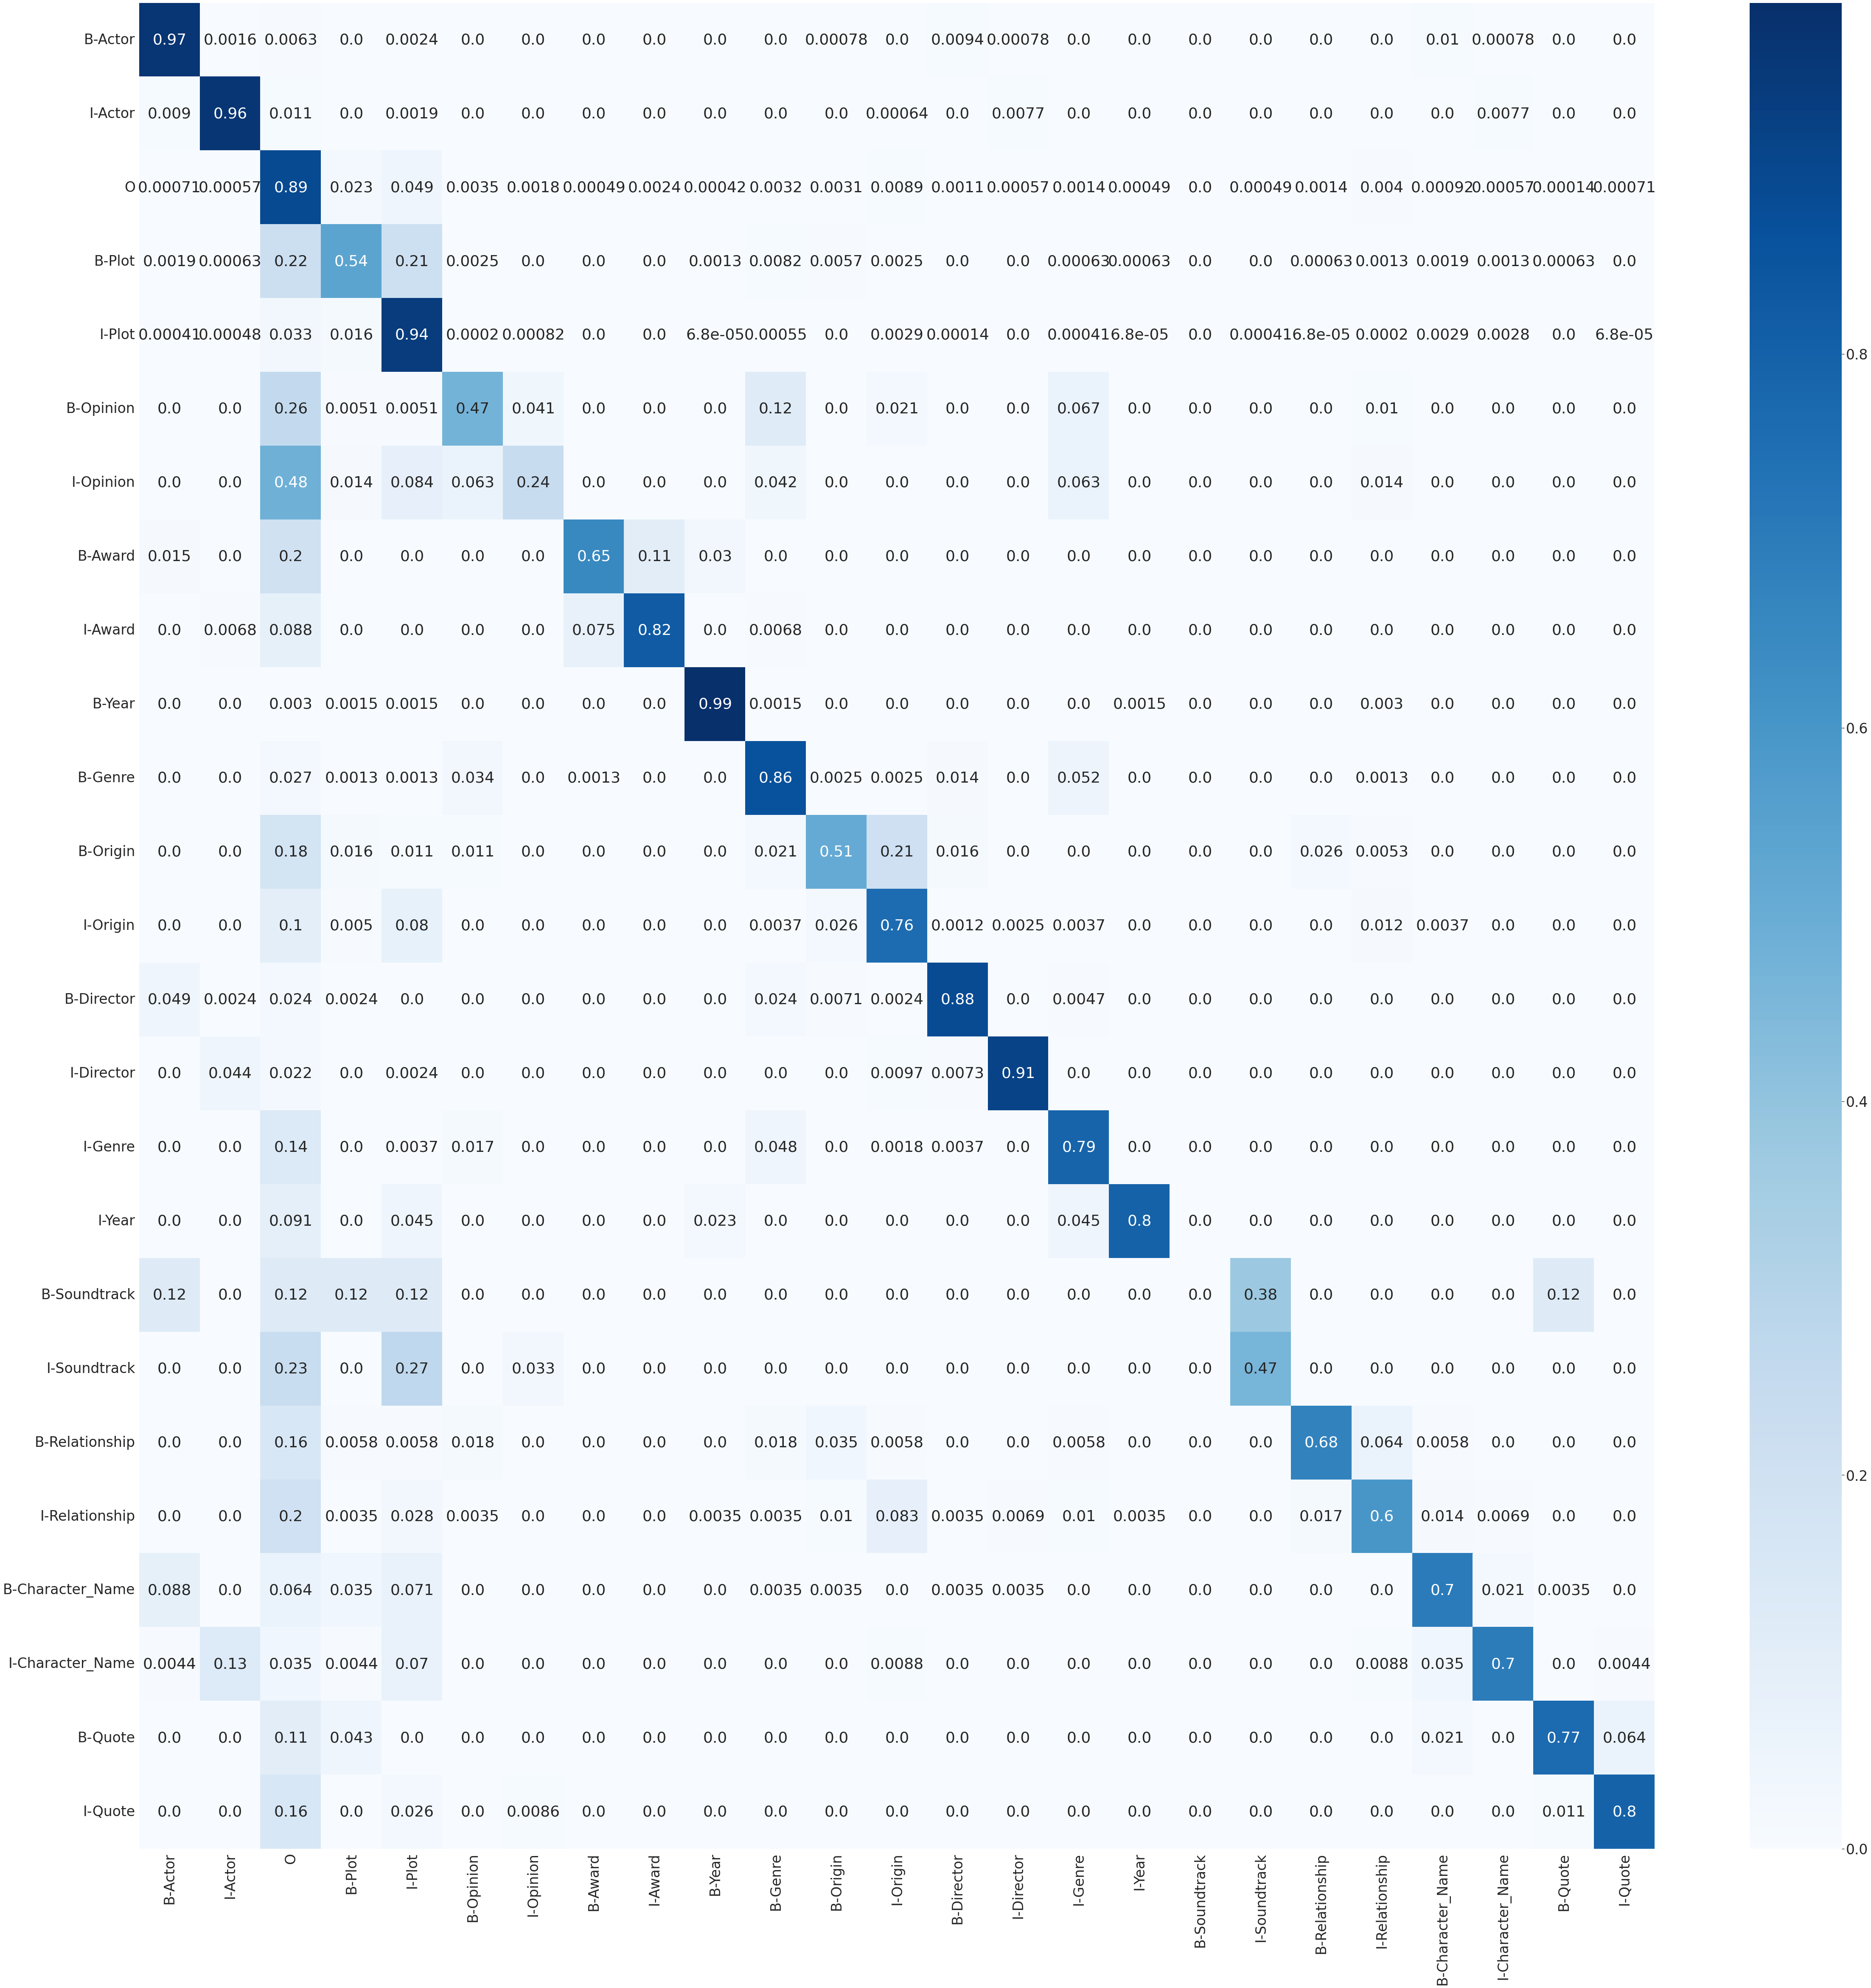

In [54]:
def plot_confusion_matrix(y_test,y_scores, classNames):
    #y_test=np.argmax(y_test, axis=1)
    #y_scores=np.argmax(y_scores, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores, labels=classNames)
    #print("**** Confusion Matrix ****")
    #print(cm)
    df_cm_st = pd.DataFrame(cm).transpose()
    df_cm_st.to_csv('output_matrix/easy_transformer_confusion_matrix.csv')
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    cr = classification_report(y_test, y_scores, target_names=classNames, output_dict=True)
    df_cr_st = pd.DataFrame(cr).transpose()
    df_cr_st.to_csv('output_matrix/easy_transformer_classification_report.csv')
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y]/np.sum(cm[x,:])

    plt.figure(figsize=(80,80))
    sns.set(font_scale=3.0) # for label size
    df = sns.heatmap(con, annot=True,fmt='.2', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    df.figure.savefig("output_matrix/simple-transformer-heatmap.png")


plot_confusion_matrix(actual_labels, predicted_labels, labels) 

# Lessons Learnt and Potential Improvements



1.  NER classification is a token based classification where I had to represent every word with its equivalent label and there is high chance of making some kind of mistake if designing own algorithm like data preprocessing or in training unlike other classification which are more straightforward.


2.   The way BERT tokenize words is unique, it uses wordpiece tokenization instead of whole word.
For example: If I tokenize the sentence "Steve mcqueen provided a thrilling..."
Bert will break it down like this ['s', '##te', '##ve', 'm', '##c', '##que', '##en', 'provided', 'a', 'thrill', '##ing',..] 
giving you a list of word pieces which are longer and can be prone to error, also if a sentence is too complex it will be broken into multiple sentences for crossing max sentence limit which can cause failure for model to learn well.


3. I started with just 1 epoch and then went on till 5 epochs and by increasing number of epochs the model got better and better at prediction.


4. Certain hyper-parameters like learning rate, does play a key role and having too low/high learning rate like 3e-5 with just 3 epoch's for fine tuning didn't give me a great model, but increasing the learning rate slight 3e-4 did give me good results.


5. I used the BERT cased model as my base model, before fine tuning it with custom data and tags, however I believe having sufficient data on Cased tags is something we need to investigate on, if my custom data has little cased tokens then model won't generalize well. For instance, my data had B-Quote  126, B-Soundtrack    50 data entries in training and all might not be Upper or lower case and it would be unfair on model if it didn't pick that up in test.


6. After splitting train-validation data I tried random shuffler for training data and my model performed very poorly with it. 


7. Even the performance evaluation type plays a key in scoring the model,
Our task includes (B- I-) tags showing its beginning or includes and there is case where model misclassified those but correctly classified the parent tag.
so is our evaluation strict or relaxed on prefix of label also matters.







# Learning Resources

**Research Papers**

1. [Attention Is All You Need](https://arxiv.org/abs/1706.03762)

2. [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)

3. [BERT Explained](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)

4. [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)


**Learning Materials, Packages and documentation**

1. [Hugging Face - The AI community building the future](https://huggingface.co)

2. [Simple Transformers - Using Transformer models has never been simpler!](https://simpletransformers.ai/)

3. [Named entity recognition with Bert](https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/)